In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

2024-08-15 17:32:58.343602: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 17:32:58.769633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [7]:
contact_threshold = 250

In [8]:
esc_contact_maps = esc_maps_interp < 250
cnc_contact_maps = cnc_maps_interp < 250

In [15]:
def count_stack_contacts(contact_maps):
    num_contacts_15 = np.sum(contact_maps[15, 15:42])
    num_contacts_42 = np.sum(contact_maps[15:42, 42])
    return num_contacts_15 + num_contacts_42

In [16]:
esc_stack_count = [count_stack_contacts(x) for x in esc_contact_maps]
cnc_stack_count = [count_stack_contacts(x) for x in cnc_contact_maps]

In [18]:
# Put stack counts into a dataframe
esc_df = pd.DataFrame(esc_stack_count, columns=['stack_count'])
esc_df['cell_type'] = 'ESC'
cnc_df = pd.DataFrame(cnc_stack_count, columns=['stack_count'])
cnc_df['cell_type'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df])

In [82]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240813'

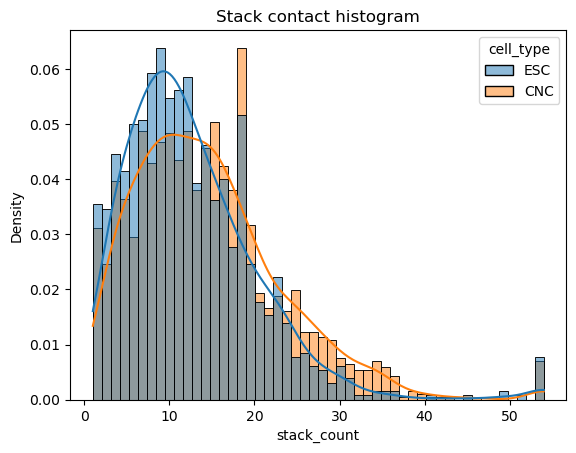

In [83]:
# Plot the stack counts on histogram
sns.histplot(all_df, x='stack_count', hue='cell_type', 
             stat='density', common_norm=False,
             bins=50, kde=True)
plt.title('Stack contact histogram')
plt.savefig(save_dir + '/stack_contact_histogram.png', dpi=300, bbox_inches='tight')

In [74]:
bins = np.arange(0, 51, 5)
labels = np.arange(10)
print(bins)
print(labels)

[ 0  5 10 15 20 25 30 35 40 45 50]
[0 1 2 3 4 5 6 7 8 9]


In [75]:
esc_stack_bins = pd.cut(esc_stack_count, bins, labels=labels)
cnc_stack_bins = pd.cut(cnc_stack_count, bins, labels=labels)

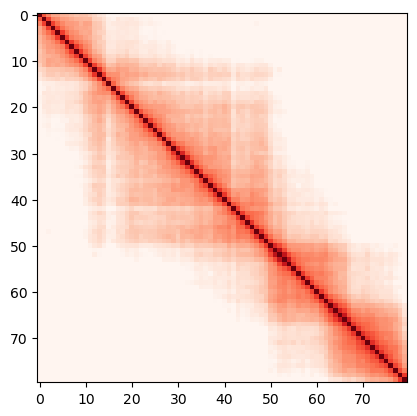

In [60]:
plt.imshow(np.median(esc_maps_interp[esc_stack_bins == 0], 0), cmap='Reds_r', vmax=600)

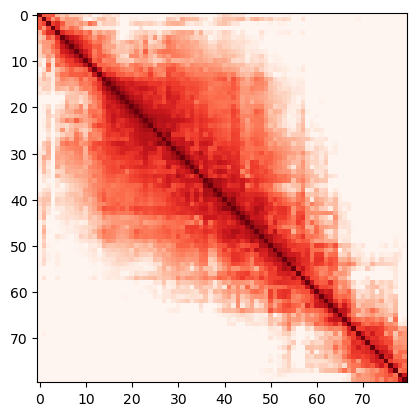

In [70]:
plt.imshow(np.median(esc_maps_interp[esc_stack_bins == 3], 0), cmap='Reds_r', vmax=600)

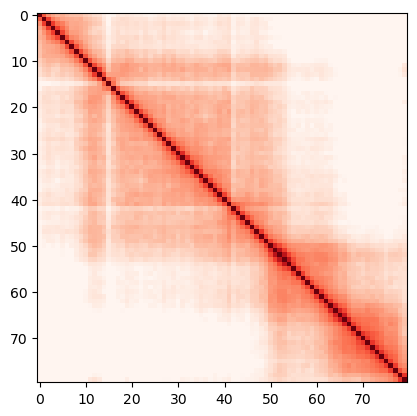

In [67]:
plt.imshow(np.median(cnc_maps_interp[cnc_stack_bins == 0], 0), cmap='Reds_r', vmax=600)

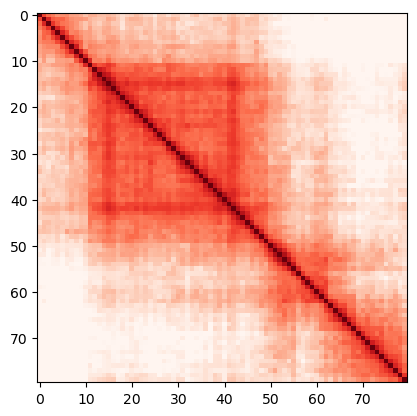

In [69]:
plt.imshow(np.median(cnc_maps_interp[cnc_stack_bins == 3], 0), cmap='Reds_r', vmax=600)

In [78]:
# Combine data from esc and cnc that are assigned to the same bin
all_stack_bins = np.concatenate((esc_stack_bins, cnc_stack_bins))
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)


In [84]:
distance_maps_bins = []
count_bins = []
for i in range(10):
    distance_maps_bins.append(np.median(all_maps_interp[all_stack_bins == i], 0))
    count_bins.append(np.sum(all_stack_bins == i))

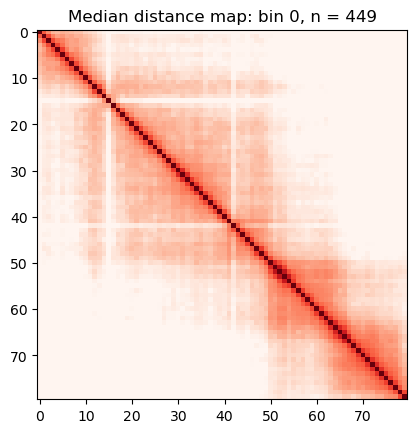

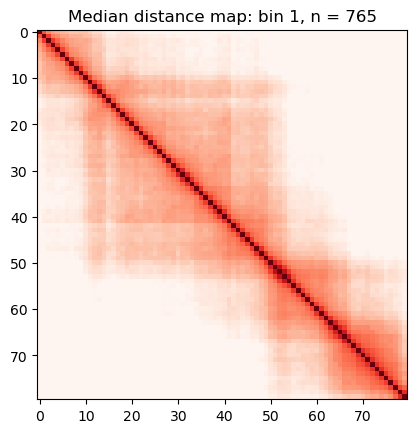

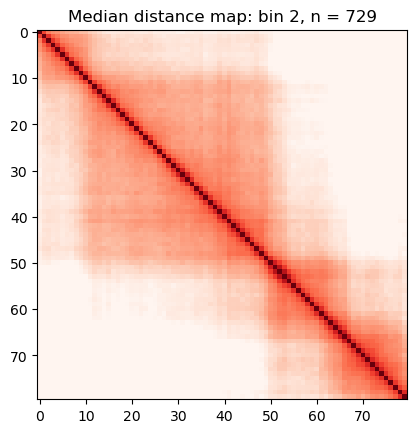

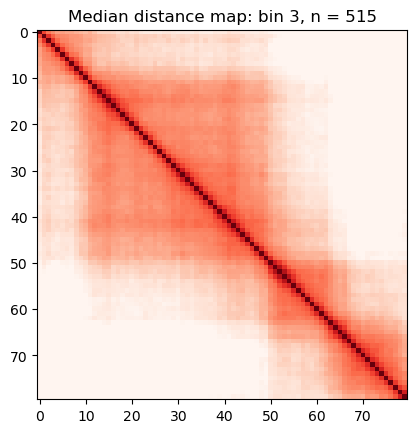

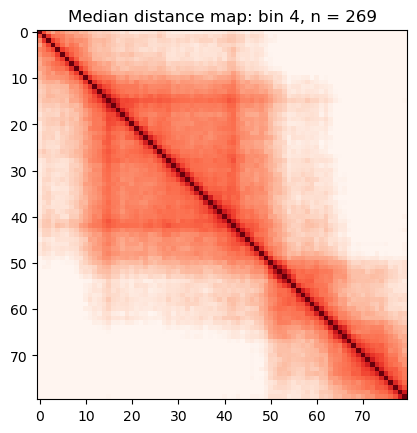

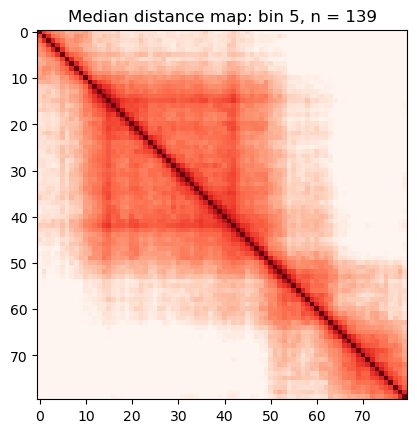

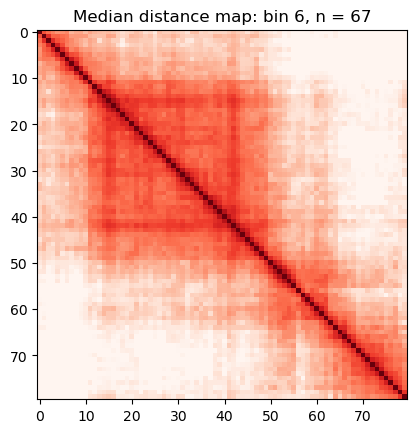

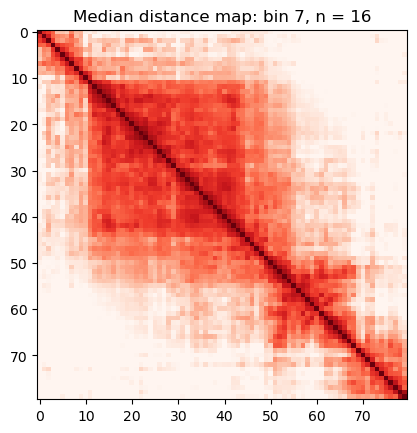

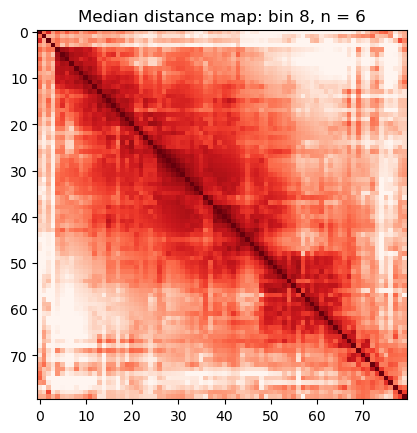

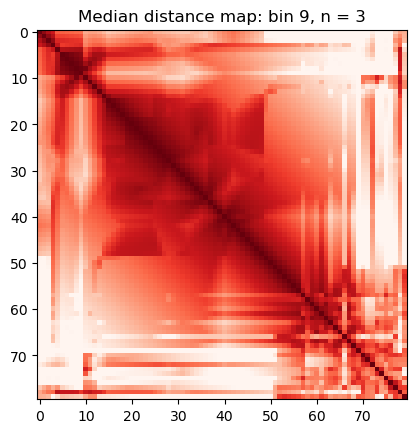

In [87]:
for i, x in enumerate(distance_maps_bins):
    plt.imshow(x, cmap='Reds_r', vmax=600)
    plt.title('Median distance map: bin {}, n = {}'.format(i, count_bins[i]))
    plt.savefig(save_dir + '/median_distance_map_bin_{}.png'.format(i), dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Do reweighting on these median structures 

In [24]:
def radius_of_gyration(poly):
    num_probes, _ = poly.shape
    center = np.mean(poly, axis=0)
    return np.sqrt(np.sum(np.linalg.norm(poly - center, axis=1)**2) / num_probes)

In [42]:
esc_rg = [radius_of_gyration(esc_polys_interp[:,:,x]) for x in range(esc_polys_interp.shape[2])]
cnc_rg = [radius_of_gyration(cnc_polys_interp[:,:,x]) for x in range(cnc_polys_interp.shape[2])]

In [43]:
# Put the data into a dataframe
esc_df['rg'] = esc_rg
cnc_df['rg'] = cnc_rg
all_df = pd.concat([esc_df, cnc_df])

<Axes: xlabel='rg', ylabel='Density'>

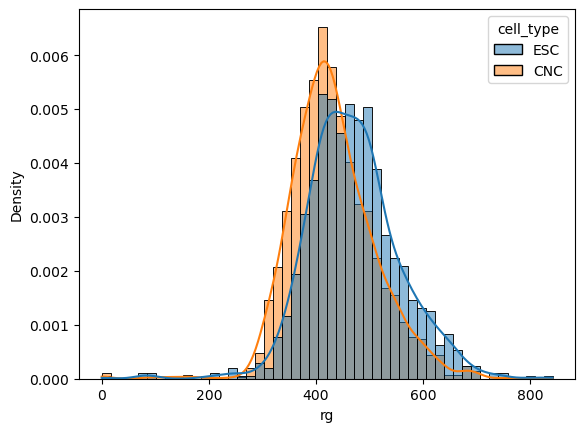

In [44]:
# Plot the radius of gyration on histogram
sns.histplot(all_df, x='rg', hue='cell_type', 
             stat='density', common_norm=False,
             bins=50, kde=True)


<Axes: xlabel='rg', ylabel='stack_count'>

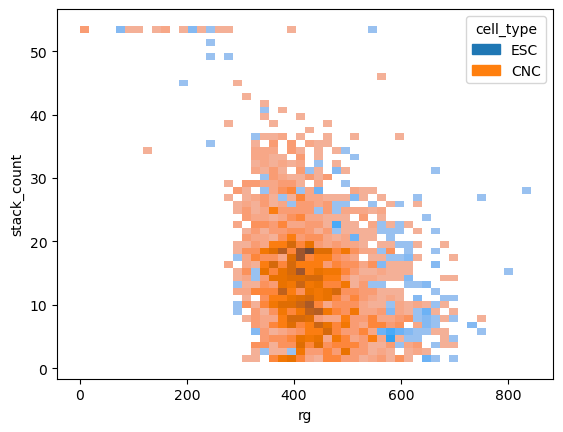

In [45]:
# Plot the radius of gyration on histogram
sns.histplot(all_df, x='rg', y='stack_count', hue='cell_type', 
             stat='density', common_norm=False,
             bins=50, kde=True)


In [88]:
# Analyze the reweighting results 
# Load the reweighted structures
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240813_WeightMCMC_stack_contact'

In [89]:
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')

In [91]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [92]:
esc_log_weights = load_weights(stan_directory_esc, 10)
cnc_log_weights = load_weights(stan_directory_cnc, 10)
# all_log_weights = load_weights(stan_directory_all, 2500)

['20240715_WeightOptimization-20240813171142_1.csv', '20240715_WeightOptimization-20240813171142_2.csv', '20240715_WeightOptimization-20240813171142_3.csv', '20240715_WeightOptimization-20240813171142_4.csv']
['20240715_WeightOptimization-20240813171205_1.csv', '20240715_WeightOptimization-20240813171205_2.csv', '20240715_WeightOptimization-20240813171205_3.csv', '20240715_WeightOptimization-20240813171205_4.csv']


In [101]:
esc_log_weights.reshape(-1, 10).shape

(4000, 10)

In [111]:
np.exp(esc_log_weights.reshape(-1, 10).flatten())[:10]

array([0.33710946, 0.49658895, 0.08285273, 0.03820335, 0.00663625,
       0.00650094, 0.02283675, 0.00198747, 0.00526766, 0.00201643])

In [112]:
np.exp(esc_log_weights.reshape(-1, 10).flatten())[11:20]

array([0.45897682, 0.07195731, 0.04033516, 0.00522507, 0.00941694,
       0.00764774, 0.00425474, 0.01460902, 0.0037716 ])

In [117]:
np.tile(np.arange(10), 2)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [118]:
# Add these log weights to the dataframe
# Reshape the log weights - 10 columns 
esc_log_weights = esc_log_weights.reshape(-1, 10)

# Then add each column to the dataframe with distinct labels
# values are in the same column, label is in another column
esc_weight_df = pd.DataFrame()
esc_weight_df['log_weight'] = np.exp(esc_log_weights.reshape(-1, 10).flatten())
esc_weight_df['label'] = np.tile(np.arange(10), esc_log_weights.reshape(-1, 10).shape[0])
esc_weight_df['cell_type'] = 'ESC'

# Do the same for CNC
cnc_log_weights = cnc_log_weights.reshape(-1, 10)
cnc_weight_df = pd.DataFrame()
cnc_weight_df['log_weight'] = np.exp(cnc_log_weights.reshape(-1, 10).flatten())
cnc_weight_df['label'] = np.tile(np.arange(10), cnc_log_weights.reshape(-1, 10).shape[0])
cnc_weight_df['cell_type'] = 'CNC'


In [120]:
all_weight_df = pd.concat([esc_weight_df, cnc_weight_df])

In [122]:
all_weight_df[all_weight_df['label'] == 0]

,log_weight,label,cell_type
0,0.337109,0,ESC
10,0.383806,0,ESC
20,0.377384,0,ESC
30,0.375218,0,ESC
40,0.368564,0,ESC
...,...,...,...
39950,0.297833,0,CNC
39960,0.319594,0,CNC
39970,0.281746,0,CNC
39980,0.314833,0,CNC


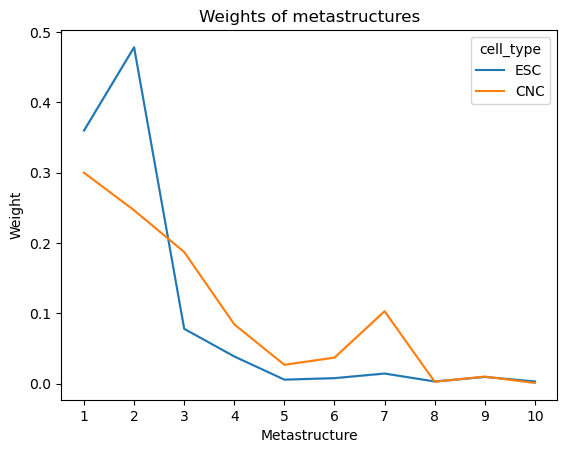

In [127]:
# Plot the log weights on a line plot with error bar using seaborn
sns.lineplot(data=all_weight_df, x='label', y='log_weight', hue='cell_type', errorbar='ci')
plt.title('Weights of metastructures')
plt.xlabel('Metastructure')
plt.ylabel('Weight')
plt.xticks(np.arange(10), np.arange(10)+1)
plt.savefig(save_dir + '/metastructure_weights.png', dpi=300, bbox_inches='tight')


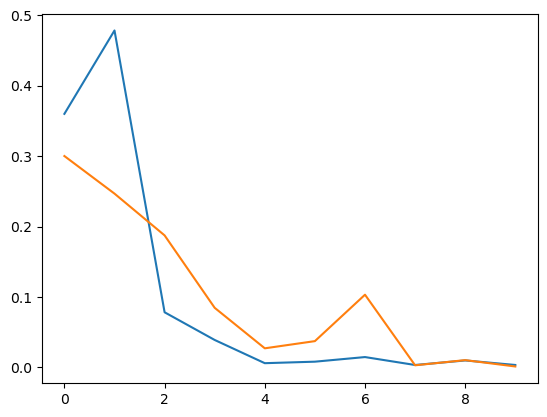

In [98]:
plt.plot(np.mean(np.exp(esc_log_weights.reshape(-1, 10)), axis=0))
plt.plot(np.mean(np.exp(cnc_log_weights.reshape(-1, 10)), axis=0))